In [ ]:
import numpy as np

import pandas as pd
import tensorflow_datasets as tfds
import tensorflow as tf

from sklearn.model_selection import train_test_split
tfds.disable_progress_bar()

In [ ]:
import os
os.chdir("/content/sample_data")
!ls
df = pd.read_csv('nlp_train.csv')
df

anscombe.json		     california_housing_train.csv  mnist_train_small.csv  README.md
california_housing_test.csv  mnist_test.csv		   nlp_train.csv


,Unnamed: 0,Text,Emotion
0,4742,i want them to feel eager to attend a amp m i ...,happy
1,15455,i did feel like things were resolved a bit too...,happy
2,19658,i said before i feel like a hypocrite advocati...,love
3,2529,i can feel she still angry with me,anger
4,12028,i can say that it is happening in the eastern ...,happy
...,...,...,...
20382,4984,i feel remorseful but i am not ready to die an...,sadness
20383,3985,i lived her life without the feeling of accept...,anger
20384,9772,i read and appreciate all comments left but if...,happy
20385,15940,i just cant help but feel that i am more intel...,happy


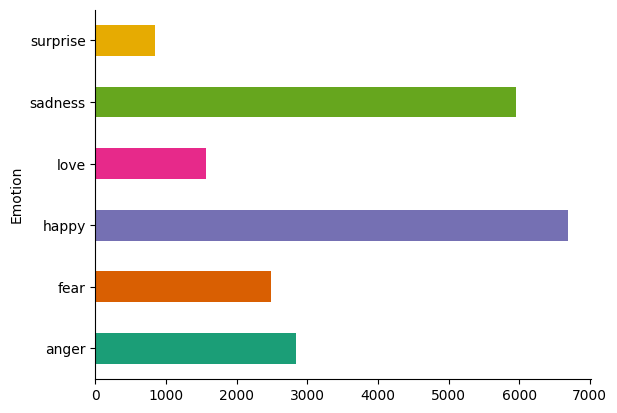

In [ ]:
# @title Emotion

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Emotion').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
example = df.sample(1)
print('text: ', example["Text"])
print('label: ',  example["Emotion"])

text:  16337    i know is that it s better for me as a teacher...
Name: Text, dtype: object
label:  16337    happy
Name: Emotion, dtype: object


In [ ]:
emotions = df["Emotion"].unique()
label_emotion = {emotion : i for i, emotion in enumerate(emotions)}
df["Emotion"] = df["Emotion"].map(label_emotion)

train_dataset, test_dataset = train_test_split(df, test_size=0.2)
train_dataset

,Unnamed: 0,Text,Emotion
16300,14589,i don t know i feel confused,4
15640,15423,i have struggled with my thyroid waking up eac...,0
10568,993,i set my mind to wanting a specific item needi...,4
9384,17808,im feeling a little anxious about the whole thing,4
10618,18519,i hope your words make you feel brave and scar...,0
...,...,...,...
8051,10093,im feeling thankful for the man snoring in bed...,0
19836,5483,i have my lowest level class first which is de...,0
10766,11187,i am not feeling fearful,4
9877,16001,im updating my blog because i feel shitty,3


In [ ]:
tf_train_dataset=tf.data.Dataset.from_tensor_slices((train_dataset["Text"].values, train_dataset["Emotion"].values))
tf_test_dataset=tf.data.Dataset.from_tensor_slices((test_dataset["Text"].values, test_dataset["Emotion"].values))
tf_test_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
for example, label in tf_train_dataset.take(1):
  print('texts: ', example.numpy())
  print()
  print('labels: ', label.numpy())

texts:  b'i don t know i feel confused'

labels:  4


In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
train_dataset = tf_train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = tf_test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'i', 'feel', 'and', 'to', 'the', 'a', 'of', 'that',
       'feeling', 'my', 'in', 'it', 'like', 'was', 'for', 'so', 'im',
       'but'], dtype='<U13')

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 128, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(emotions), activation="softmax")
])

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
255/255 [==============================] - 8s 32ms/step - loss: 0.8250 - accuracy: 0.7102 - val_loss: 0.8303 - val_accuracy: 0.7115
Epoch 2/10
255/255 [==============================] - 9s 33ms/step - loss: 0.7659 - accuracy: 0.7339 - val_loss: 0.7827 - val_accuracy: 0.7250
Epoch 3/10
255/255 [==============================] - 7s 28ms/step - loss: 0.7021 - accuracy: 0.7621 - val_loss: 0.7427 - val_accuracy: 0.7437
Epoch 4/10
255/255 [==============================] - 9s 35ms/step - loss: 0.6569 - accuracy: 0.7837 - val_loss: 0.7243 - val_accuracy: 0.7474
Epoch 5/10
255/255 [==============================] - 9s 33ms/step - loss: 0.6238 - accuracy: 0.7940 - val_loss: 0.6735 - val_accuracy: 0.7609
Epoch 6/10
255/255 [==============================] - 7s 27ms/step - loss: 0.5836 - accuracy: 0.8045 - val_loss: 0.6617 - val_accuracy: 0.7599
Epoch 7/10
255/255 [==============================] - 9s 34ms/step - loss: 0.5545 - accuracy: 0.8146 - val_loss: 0.6492 - val_accuracy: 0.7667

In [ ]:
for text, label in train_dataset.take(1):
  predictions = model.predict(text)
  for i in range(len(predictions)):
    predictions_label = tf.argmax(predictions[i]).numpy()
    prediction_emotion =[emotion for emotion,index in label_emotion.items() if index == predictions_label][0]


    print('texts: ', text[i].numpy())
    print('value of emotion', [emotion for emotion,value in label_emotion.items() if value == label[i].numpy()][0])
    print('prediction emotion: ', prediction_emotion)
    print()

2/2 [==============================] - 0s 11ms/step
texts:  b'i mean i know how it feels that a person is valued by the family if s he gives money or food to the table'
value of emotion happy
prediction emotion:  happy

texts:  b'i go in coeur d alene im surrounded by them and it feels strange to look at them and think all these people are actually as nuts as me'
value of emotion surprise
prediction emotion:  fear

texts:  b'i reconciled and life goes on as does marriage but i feel terrible for what i did to her and to the one with whom i had the affair'
value of emotion sadness
prediction emotion:  sadness

texts:  b'i feel like a crappy mummy if were stuck in but there are days where i really cant face much else then venturing out to the garden at pm'
value of emotion sadness
prediction emotion:  sadness

texts:  b'i feel extremely fond of comes an avalanche of anxiety'
value of emotion love
prediction emotion:  love

texts:  b'im left with today is feeling anxious and sad and lonely